### Import Libraries

In [67]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

### Load the Data

In [68]:
player = pd.read_csv("data.csv")

In [69]:
player.shape

(9529, 19)

In [70]:
player.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


### Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [71]:
# uniqeness
player.drop_duplicates(inplace=True)
player[player.duplicated()]

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median


In [72]:
# Completeness
player.isnull().sum()

Id                       0
team                     0
name                     0
position                 0
age                      0
appearance               0
goals                    0
assists                  0
goals conceded           0
clean sheets             0
minutes played           0
days_injured             0
games_injured            0
award                    0
current_value            0
highest_value            0
position_encoded         0
position_grouped         0
minutes_played_median    0
dtype: int64

In [73]:
# Accurecy types
player.dtypes

Id                         int64
team                      object
name                      object
position                  object
age                      float64
appearance                 int64
goals                    float64
assists                  float64
goals conceded           float64
clean sheets             float64
minutes played             int64
days_injured               int64
games_injured              int64
award                      int64
current_value              int64
highest_value              int64
position_encoded           int64
position_grouped          object
minutes_played_median    float64
dtype: object

In [74]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['position', 'name', 'team']
numeric_features = ['minutes_played_median', 'position_grouped', 'position_encoded','highest_value','current_value','award','games_injured','days_injured','minutes played','clean sheets','goals conceded','assists','goals','appearance','age']

In [75]:
for i in categorical_features:
    print (player[i].value_counts())

position
Defender Centre-Back          1683
Goalkeeper                    1172
midfield-CentralMidfield      1046
Attack Centre-Forward         1011
midfield-DefensiveMidfield     828
Defender Right-Back            808
Defender Left-Back             753
midfield-AttackingMidfield     645
Attack-RightWinger             613
Attack-LeftWinger              591
midfield-LeftMidfield           89
midfield-RightMidfield          88
midfield                        70
Attack-SecondStriker            50
Attack                          49
Defender                        33
Name: count, dtype: int64
name
Paulinho              5
Guilherme             4
Vitinho               4
Wanderson             3
Pedrinho              3
                     ..
Alisson Safira        1
Gabriel Batista       1
Ricardo Fernandes     1
Marco Pereira         1
Alexander Badolato    1
Name: count, Length: 9405, dtype: int64
team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swa

In [76]:
for i in numeric_features:
    print (player[i].value_counts())

minutes_played_median
2235.5    401
90.0       82
1530.0     39
180.0      36
360.0      32
         ... 
2131.0      1
5473.0      1
7222.0      1
219.0       1
1555.0      1
Name: count, Length: 4668, dtype: int64
position_grouped
Defender Centre-Back          1683
Goalkeeper                    1172
midfield-CentralMidfield      1046
Attack Centre-Forward         1011
midfield-DefensiveMidfield     828
Defender Right-Back            808
Defender Left-Back             753
midfield-AttackingMidfield     645
Attack-RightWinger             613
Attack-LeftWinger              591
Other                          379
Name: count, dtype: int64
position_encoded
2    3277
3    2766
4    2314
1    1172
Name: count, dtype: int64
highest_value
1000000     440
1500000     393
2000000     380
50000       334
3000000     325
           ... 
3100000       1
90000000      1
80000000      1
37000000      1
625000        1
Name: count, Length: 141, dtype: int64
current_value
1000000     429
300000      42

In [77]:
player.drop(['minutes_played_median'], axis=1, inplace=True)


## Feature Sellecting

1. Feature scaling

2. Aggregation

3. One hot coding

In [78]:
player.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper


In [79]:
categorical_features

['position', 'name', 'team']

In [80]:
# one hot coding
player = pd.get_dummies(player, columns=categorical_features)

In [81]:
player.shape

(9529, 9810)

#### 3. Feature selection

In [82]:
# only use numeric data in my model!
numeric_data = player.select_dtypes(include=[np.number])

correlation = numeric_data.corr()
print(correlation['current_value'].sort_values(ascending=False))

current_value       1.000000
highest_value       0.781221
appearance          0.453880
minutes played      0.438638
assists             0.227056
award               0.202847
games_injured       0.178456
goals               0.176177
days_injured        0.148958
position_encoded    0.082440
clean sheets       -0.016167
age                -0.052531
goals conceded     -0.078045
Id                 -0.459109
Name: current_value, dtype: float64


In [83]:
# Set the correlation threshold
threshold = 0.2

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['Id', 'appearance', 'assists', 'minutes played', 'award',
       'current_value', 'highest_value'],
      dtype='object')

In [84]:
selected_features = ['appearance', 'minutes played', 'award', 'current_value','highest_value']

In [85]:
player = player[selected_features]
player.head()

,appearance,minutes played,award,current_value,highest_value
0,15,1304,1,1500000,22000000
1,4,292,4,600000,6000000
2,68,4762,1,25000000,70000000
3,70,5471,10,15000000,35000000
4,34,2758,0,2000000,2000000


#### 4. Prepare train and test data

In [86]:
# Prepare data
X = player.drop(['current_value'], axis=1)
y = player['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Buliding the Model

In [87]:
model = LinearRegression()

##### Ridge & Lasso regularization

In [88]:
ridge_model = Ridge()

In [89]:
lasso_model = Lasso()

In [90]:
param_grid = {
    'alpha': [ 0, 0.000001,0.0001, 0.001, 0.01, 0.1, 1 ]  # Regularization strength
}
grid_search = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

### Train the Model

In [91]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

##### Ridge & Lasso regularization

In [92]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [93]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [94]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 1e-06, 0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [95]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 1e-06, 0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [96]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

##### Ridge & Lasso regularization

In [97]:
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [98]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [99]:
# Best hyperparameter
print("Best parameters found 'Ridge': ", grid_search.best_params_)

# Best model
best_ridge = grid_search.best_estimator_

Best parameters found 'Ridge':  {'alpha': 1}


In [100]:
# Best hyperparameter
print("Best parameters found 'Lasso': ", grid_search_lasso.best_params_)

# Best model
best_ridge = grid_search_lasso.best_estimator_

Best parameters found 'Lasso':  {'alpha': 1}


In [101]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

## Interpretation of the Model

In [102]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.347608e+05
minutes played,8.607979e+05
award,-3.943430e+05
highest_value,3.192549e+06


In [103]:
print(model.intercept_)

2370334.5139708775


##### Ridge & Lasso regularization

In [104]:
coeff_df = pd.DataFrame(lasso_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.347415e+05
minutes played,8.607793e+05
award,-3.943416e+05
highest_value,3.192547e+06


In [105]:
coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.333276e+05
minutes played,8.595260e+05
award,-3.941313e+05
highest_value,3.191940e+06


In [106]:
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.347415e+05
minutes played,8.607793e+05
award,-3.943416e+05
highest_value,3.192547e+06


1. Mean Square Error

In [107]:
y_base = [y_train.mean()] * len(y_test)

In [108]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 17940161195144.867


In [109]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 6006757380125.92
Mean Squared Error for testing: 7488659152144.055


2. Mean Absolute Error

In [110]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 2597997.930477421


In [111]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1312920.2662755903
Mean Absolute Error for testing: 1413385.2055992733


3. Root Mean Absolute Error

In [112]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1611.8306146979032


In [113]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2450868.699079149
Root Mean Squared Error for testing: 2736541.458144578


4. R Square

In [114]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.6595416350786527
R Square for testing: 0.5824947179715643


In [115]:
predictions = model.predict(X_test_scaled)
#predictions

In [116]:
Real_Values = np.array(y_test)
#Real_Values

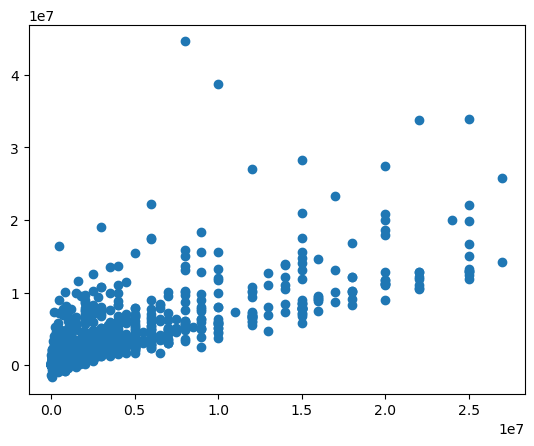

In [117]:
plt.scatter(Real_Values,predictions); 


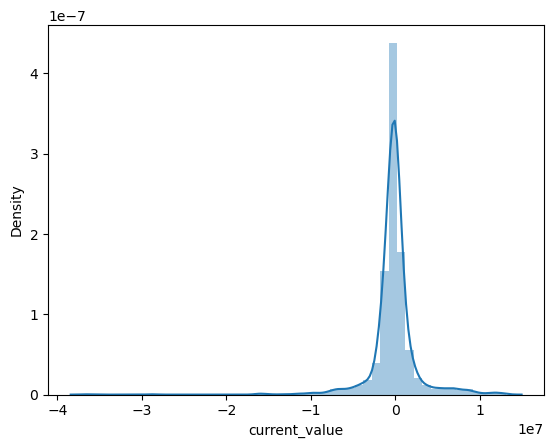

In [118]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution
